## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from typing import Dict, Any
from tqdm.auto import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import pipeline
from transformers.models.whisper import (WhisperTokenizer,
                                         WhisperTokenizerFast,
                                         WhisperFeatureExtractor,
                                         WhisperForConditionalGeneration)
from datasets import load_dataset

from dataloader.dataset_loader import gen_from_dataset
from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP
from evaluation.string_edit_metrics import get_string_edit_metrics

from utils.constants import GEN_MAX_LENGTH, DEFAULT_EVAL_NUM_BEAMS

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

## User input

## Load model

In [4]:
pretrained_model_name_or_path = "openai/whisper-tiny"

model = WhisperForConditionalGeneration.from_pretrained(pretrained_model_name_or_path)
feature_extractor = WhisperFeatureExtractor.from_pretrained(pretrained_model_name_or_path)
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")


model.config.forced_decoder_ids = tokenizer.get_decoder_prompt_ids(language="english", task="transcribe")
model.config.suppress_tokens = []

whisper_norm = tokenizer._normalize

## Load dataset

In [8]:
dataset_name = "ami_10h"

ds_group = EVAL_DATASET_NAME_TO_DATASET_GROUP[dataset_name]()

if dataset_name == "librispeech_dummy":
    ds = ds_group.str2dataset["librispeech_dummy"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
elif dataset_name in ["ami", "ami_10h"]:
    ds = ds_group.str2dataset["ami"]
    ds = ds.map(lambda x: {"text": x.lower()}, input_columns=["text"])
else:
    raise ValueError()

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)


Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

## Create pipeline

In [9]:
whisper_asr = pipeline(task="automatic-speech-recognition",
                       model=model,
                       tokenizer=tokenizer,
                       feature_extractor=feature_extractor,  # type: ignore
                       device=device
)

## Run pipeline

In [10]:
generate_kwargs = {"max_length": GEN_MAX_LENGTH, "num_beams": DEFAULT_EVAL_NUM_BEAMS}

# Create placeholders for the predictions and references:
predictions = []
references = []

for out in tqdm(whisper_asr(gen_from_dataset(ds),
                            batch_size=32,
                            generate_kwargs=generate_kwargs),
                total=ds.num_rows):
    ref = out["reference"][0].lower()
    pred = out["text"].lower()
    references.append(ref)
    predictions.append(pred)

  0%|          | 0/1264 [00:00<?, ?it/s]

## Compute string edit metrics

In [11]:
string_edit_metrics = 100 * pd.Series(get_string_edit_metrics(references=references, predictions=predictions))

string_edit_metrics

wer    53.522505
sub    36.231479
del    11.126642
ins     6.164384
dtype: float64

## Analysis

### Add audio length to the dataset features

In [12]:
def get_audio_length_in_seconds(x: Dict[str, Any]) -> Dict[str, float]:
    assert "audio" in x  # TODO
    audio = x["audio"]
    audio_length = len(audio["array"]) / audio["sampling_rate"]
    return {"audio_length": audio_length}

In [13]:
ds = ds.map(get_audio_length_in_seconds)

ds.features

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'audio_length': Value(dtype='float64', id=None)}

### Add predictions to the dataset features

In [14]:
assert ds.num_rows == len(references) == len(predictions)
ds = ds.add_column(name="pred", column=predictions)

ds.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'pred': Value(dtype='string', id=None)}

### Tokenize both labels and predictions

In [15]:
ds = ds.map(lambda batch: {"labels": tokenizer(batch["text"]).input_ids,
                           "pred_tokenized": tokenizer(batch["pred"]).input_ids},
            batched=True)

ds.features

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'pred': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'pred_tokenized': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

### Add n_tokens to the dataset features

In [16]:
ds = ds.map(lambda x: {"n_tokens_labels": len(x["labels"]), "n_tokens_pred": len(x["pred_tokenized"])})

ds.features

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'pred': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'pred_tokenized': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_pred': Value(dtype='int64', id=None)}

### Get DataFrame

In [17]:
cols_of_interest = ["audio_length", "text", "labels", "n_tokens_labels", "pred", "pred_tokenized", "n_tokens_pred"]
df = pd.DataFrame({col: ds[col] for col in cols_of_interest})

df["diff_n_tokens"] = df["n_tokens_pred"] - df["n_tokens_labels"]

df.head()

,audio_length,text,labels,n_tokens_labels,pred,pred_tokenized,n_tokens_pred,diff_n_tokens
0,1.37,yeah,"[50258, 50259, 50359, 50363, 19650, 50257]",6,thank you.,"[50258, 50259, 50359, 50363, 220, 40683, 291, ...",9,3
1,0.37,mm-hmm,"[50258, 50259, 50359, 50363, 2174, 12, 10250, ...",8,mm-hmm.,"[50258, 50259, 50359, 50363, 11169, 12, 10250,...",9,1
2,1.18,yeah we're gonna meet up,"[50258, 50259, 50359, 50363, 19650, 321, 434, ...",11,"yeah, we're going to meet up.","[50258, 50259, 50359, 50363, 1338, 11, 321, 43...",15,4
3,1.36,i mean we're not even there yet,"[50258, 50259, 50359, 50363, 72, 914, 321, 434...",14,we're not even there yet.,"[50258, 50259, 50359, 50363, 321, 434, 406, 75...",13,-1
4,0.29,yeah,"[50258, 50259, 50359, 50363, 19650, 50257]",6,yeah.,"[50258, 50259, 50359, 50363, 1338, 13, 50257]",7,1


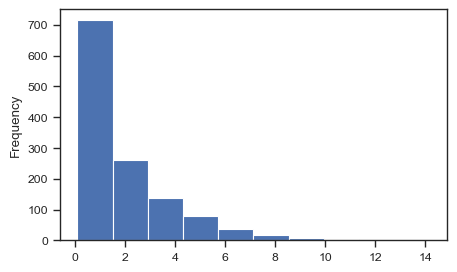

In [18]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

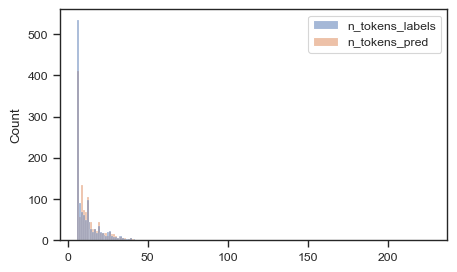

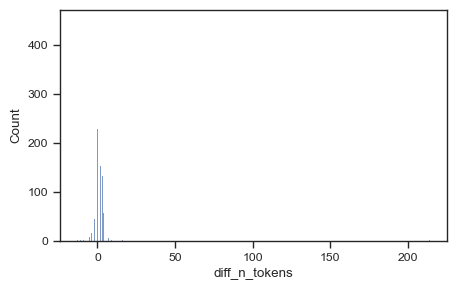

In [19]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df[["n_tokens_labels", "n_tokens_pred"]])

plt.figure(figsize=(5, 3))
sns.histplot(data=df["diff_n_tokens"]);

In [27]:
df["n_tokens_labels"].value_counts(bins=10, sort=False)

(5.955, 10.4]    753
(10.4, 14.8]     192
(14.8, 19.2]     111
(19.2, 23.6]      69
(23.6, 28.0]      66
(28.0, 32.4]      33
(32.4, 36.8]      20
(36.8, 41.2]      13
(41.2, 45.6]       5
(45.6, 50.0]       2
Name: n_tokens_labels, dtype: int64

In [24]:
df["n_tokens_labels"].describe()

count    1264.000000
mean       12.037975
std         7.961118
min         6.000000
25%         6.000000
50%         9.000000
75%        15.000000
max        50.000000
Name: n_tokens_labels, dtype: float64

In [28]:
df["n_tokens_pred"].value_counts(bins=10, sort=False)

(5.779, 28.0]     1180
(28.0, 50.0]        82
(50.0, 72.0]         1
(72.0, 94.0]         0
(94.0, 116.0]        0
(116.0, 138.0]       0
(138.0, 160.0]       0
(160.0, 182.0]       0
(182.0, 204.0]       0
(204.0, 226.0]       1
Name: n_tokens_pred, dtype: int64

In [29]:
df["n_tokens_pred"].describe()

count    1264.000000
mean       13.174842
std         9.885583
min         6.000000
25%         7.000000
50%        10.000000
75%        16.000000
max       226.000000
Name: n_tokens_pred, dtype: float64

In [33]:
df["diff_n_tokens"].value_counts(bins=10, sort=False)

(-13.228, 9.7]    1262
(9.7, 32.4]          1
(32.4, 55.1]         0
(55.1, 77.8]         0
(77.8, 100.5]        0
(100.5, 123.2]       0
(123.2, 145.9]       0
(145.9, 168.6]       0
(168.6, 191.3]       0
(191.3, 214.0]       1
Name: diff_n_tokens, dtype: int64

In [31]:
df["diff_n_tokens"].describe()

count    1264.000000
mean        1.136867
std         6.387421
min       -13.000000
25%         0.000000
50%         1.000000
75%         2.000000
max       214.000000
Name: diff_n_tokens, dtype: float64

(-15.0, 30.0)

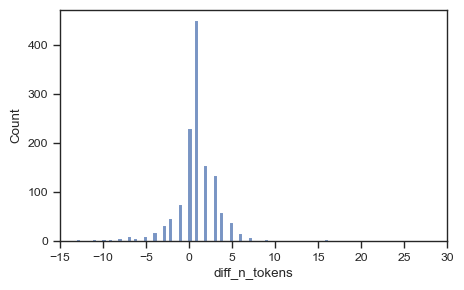

In [36]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df["diff_n_tokens"])
plt.xlim(-15, 30)

In [43]:
df_candidates = df[df["diff_n_tokens"]>=10]

In [44]:
for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["pred"])
    print()

Idx = 38
Reference:  but well whatever it was last week then
Prediction:   but... i mean, this week's only two days all. well, whatever it was last week then.

Idx = 223
Reference:  what's you what would you prefer
Prediction:   what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what's your, what

